# GOAL : 使用Linear Regressgion 做PM2.5
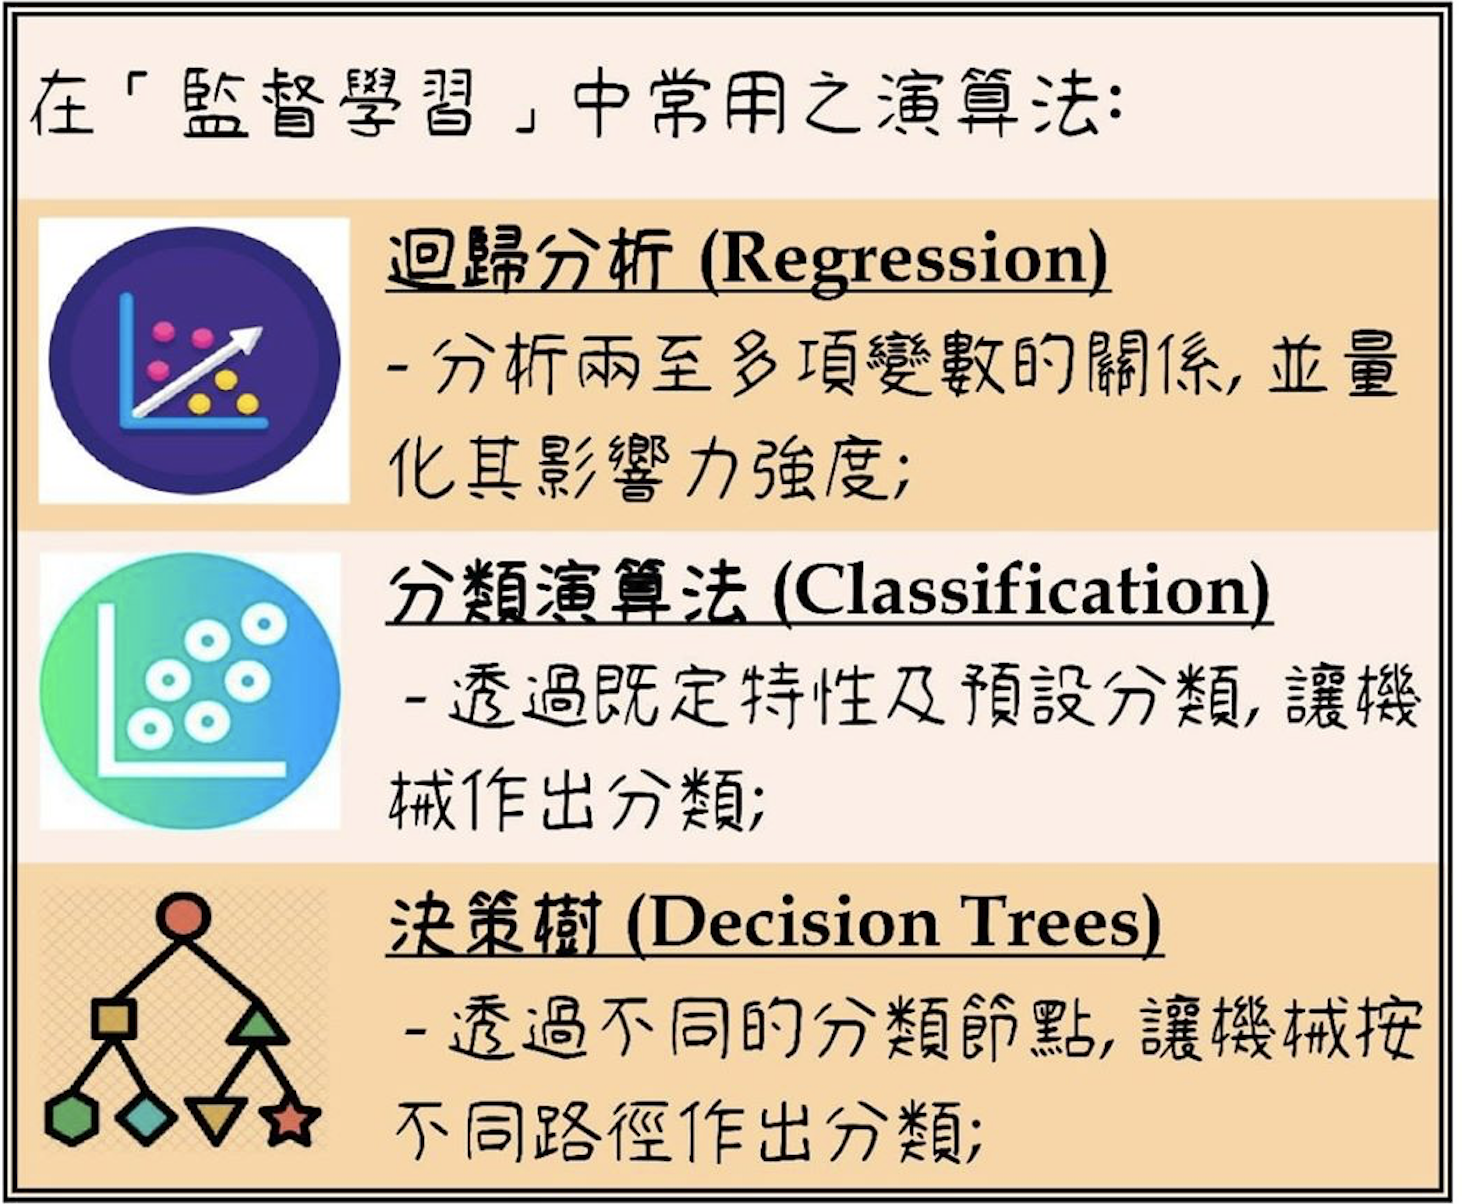

### 資料及介紹：
- train.csv: 每個月前 20 天的完整資料。
- test.csv : 從剩下的資料當中取樣出連續的 10 小時為一筆，前九小時的所有觀測數據當作 feature，第十小時的 PM2.5 當作 answer。一共取出 240 筆不重複的 test data，請根據 feature 預測這 240 筆的 PM2.5。

### 解壓縮資料集

In [131]:
!unzip ml2020spring-hw1.zip
!ls

unzip:  cannot find or open ml2020spring-hw1.zip, ml2020spring-hw1.zip.zip or ml2020spring-hw1.zip.ZIP.
'HW1_Linear Regression.ipynb'   sample_submission.csv   test.csv   train.csv


In [157]:
import sys
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 100) # 不限制行數
pd.set_option('display.max_rows', 100) # 不限制列數

### Read the csv

In [158]:
data = pd.read_csv('./train.csv', encoding='big5')
data

,日期,測站,測項,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
0,2014/1/1,豐原,AMB_TEMP,14,14,14,13,12,12,12,12,15,17,20,22,22,22,22,22,21,19,17,16,15,15,15,15
1,2014/1/1,豐原,CH4,1.8,1.8,1.8,1.8,1.8,1.8,1.8,1.8,1.8,1.8,1.8,1.8,1.8,1.8,1.8,1.8,1.8,1.8,1.8,1.8,1.8,1.8,1.8,1.8
2,2014/1/1,豐原,CO,0.51,0.41,0.39,0.37,0.35,0.3,0.37,0.47,0.78,0.74,0.59,0.52,0.41,0.4,0.37,0.37,0.47,0.69,0.56,0.45,0.38,0.35,0.36,0.32
3,2014/1/1,豐原,NMHC,0.2,0.15,0.13,0.12,0.11,0.06,0.1,0.13,0.26,0.23,0.2,0.18,0.12,0.11,0.1,0.13,0.14,0.23,0.18,0.12,0.1,0.09,0.1,0.08
4,2014/1/1,豐原,NO,0.9,0.6,0.5,1.7,1.8,1.5,1.9,2.2,6.6,7.9,4.2,2.9,3.4,3,2.5,2.2,2.5,2.3,2.1,1.9,1.5,1.6,1.8,1.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4315,2014/12/20,豐原,THC,1.8,1.8,1.8,1.8,1.8,1.7,1.7,1.8,1.8,1.8,1.8,1.8,1.8,1.8,1.8,1.8,2,2.1,2,1.9,1.9,1.9,2,2
4316,2014/12/20,豐原,WD_HR,46,13,61,44,55,68,66,70,66,85,67,60,61,60,59,308,327,21,100,109,108,114,108,109
4317,2014/12/20,豐原,WIND_DIREC,36,55,72,327,74,52,59,83,106,105,60,62,58,75,18,311,52,54,121,97,107,118,100,105
4318,2014/12/20,豐原,WIND_SPEED,1.9,2.4,1.9,2.8,2.3,1.9,2.1,3.7,2.8,3.8,4.1,3.2,3.1,2.8,2.3,2.6,1.3,1,1.5,1,1.7,1.5,2,2


### 數據處理檢查

In [159]:
data.isnull().sum() # 檢查是否有null
data.describe() # 描述資料分布

,日期,測站,測項,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
count,4320,4320,4320,4320,4320,4320,4320,4320,4320,4320,4320,4320,4320,4320,4320,4320,4320,4320,4320,4320,4320,4320,4320,4320,4320,4320,4320
unique,240,1,18,369,361,351,355,353,342,356,406,413,412,399,427,429,420,423,411,409,423,405,374,366,374,382,370
top,2014/4/6,豐原,WS_HR,NR,NR,NR,NR,NR,NR,NR,NR,NR,NR,NR,NR,NR,NR,NR,NR,NR,NR,NR,NR,NR,NR,NR,NR
freq,18,4320,240,221,225,229,226,229,230,226,230,226,231,225,225,222,218,220,219,221,221,222,223,225,224,226,224


### 將RAINFALL 中的 NR 改為0
- iloc 與 loc的差別
    - loc 基於行標籤和列標籤（x_label、y_label）進行索引
    - iloc 基於行索引和列索引（index，columns） 都是從 0 開始


In [160]:
data = data.iloc[:,3:]
# data.iloc[10,3]
data[data == 'NR']= 0
# data.iloc[10,3]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3530: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(-key, value, inplace=True)


In [161]:
data = np.array(data) # convert DataFrame to Numpy type
print(data.shape)
data

(4320, 24)


array([['14', '14', '14', ..., '15', '15', '15'],
       ['1.8', '1.8', '1.8', ..., '1.8', '1.8', '1.8'],
       ['0.51', '0.41', '0.39', ..., '0.35', '0.36', '0.32'],
       ...,
       ['36', '55', '72', ..., '118', '100', '105'],
       ['1.9', '2.4', '1.9', ..., '1.5', '2', '2'],
       ['0.7', '0.8', '1.8', ..., '1.6', '1.8', '2']], dtype=object)

### Extract Features
#### (1) 按月份來處理數據
- 每月20天(20*24),18個features 切成 12個 [18,480]

In [162]:
month_data = {}
for month in range(12):
    sample = np.empty([18,480])
    for day in range(20):
        sample[:,day*24 : (day+1)*24] = data[18 * (20 * month + day) : 18 * (20 * month + day + 1):]
    month_data[month] = sample

#### (2) 擴充數據集，獲得更好的訓練效果
1. 根據實驗要求，需要用連續9個時間點的數據預測第10个個時間點的PM2.5。 而每個月採取的是前20天連續的數據，可以擴展成480小時的連續數據；
2. 具體做法，每個月的第一天的0-8時的數據作為訓練數據，9時的數據作為標籤y；1-9的數據做一個data，10時的數據作標籤y.....以此推，每個月480小时，有480-9= 471個data，故此時總數據471\*12 個；而每個data是 18\*9 = 162
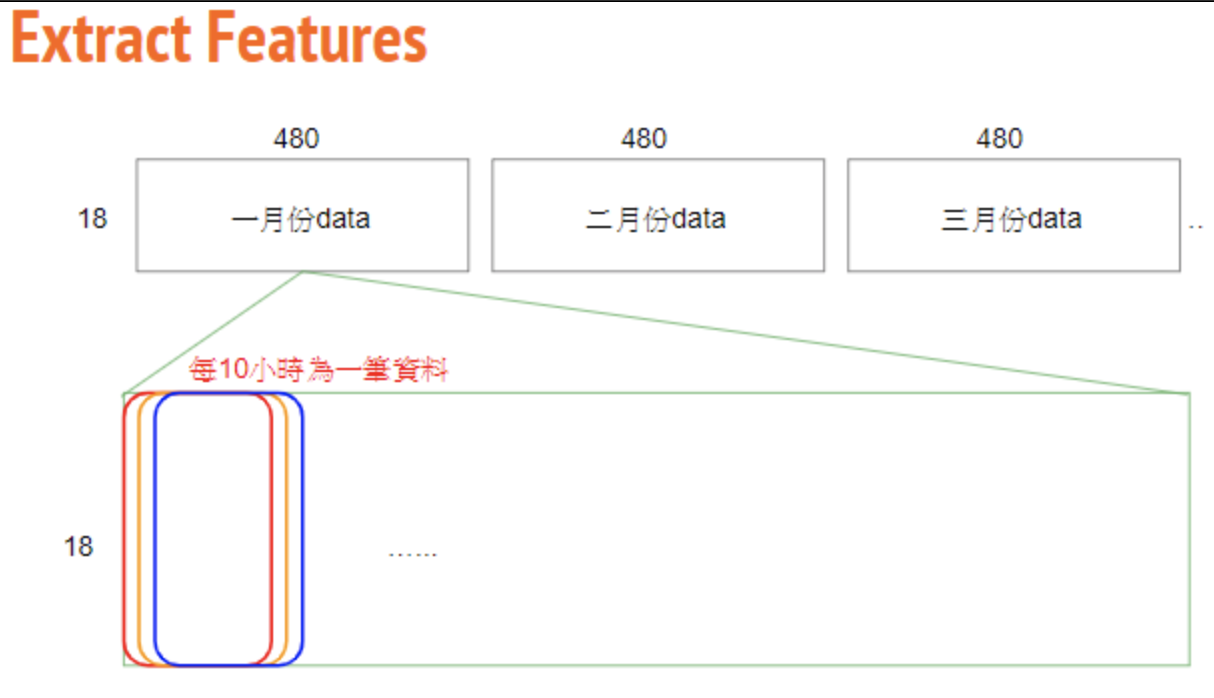

In [163]:
x = np.empty([12 * 471 , 18 * 9] , dtype = float)
y = np.empty([12 * 471 , 1] , dtype = float)
for month in range(12):
    for day in range(20):
        for hour in range(24):
            if day == 19 and hour > 14 :
                #當達到以上條件時，已經是該月的最後一筆data
                #當hour == 15, 此時y會取[9 , 19*24 + 15 + 9] = [9 ,480]已經超過index 
                continue
            #reshape將矩陣重整為新的行列數，参數-1代表自動推斷,這裏去掉了18*9的二维属性，
            #转而以一维序列代替
            ### 一維序列的順序本身可以隱含其時序訊息 ###
            x[471 * month + day *24 + hour , :] = month_data[month][:,day * 24 + hour : day *24 +hour +9].reshape(1,-1)
            y[471 * month + day *24 + hour , 0] = month_data[month][9 ,day *24 +hour +9] # 第9列為pm2.5 的answer 
print(x)
print(y)

[[14.  14.  14.  ...  2.   2.   0.5]
 [14.  14.  13.  ...  2.   0.5  0.3]
 [14.  13.  12.  ...  0.5  0.3  0.8]
 ...
 [17.  18.  19.  ...  1.1  1.4  1.3]
 [18.  19.  18.  ...  1.4  1.3  1.6]
 [19.  18.  17.  ...  1.3  1.6  1.8]]
[[30.]
 [41.]
 [44.]
 ...
 [17.]
 [24.]
 [29.]]


### Normailz 正規化
[莫凡講解](https://morvanzhou.github.io/tutorials/machine-learning/ML-intro/3-02-normalization/)
- 主要是不希望某些特徵形成主導作用
- 經過Standardization之後，資料會符合常態分佈，不會有偏單邊的形況，由於常態分佈機器學習的加權迭代學習(梯度下降)可以更容易完成。另外Standardization還可以使離群值(outlier)對整個model的影響大大減低。

### axis 示意圖
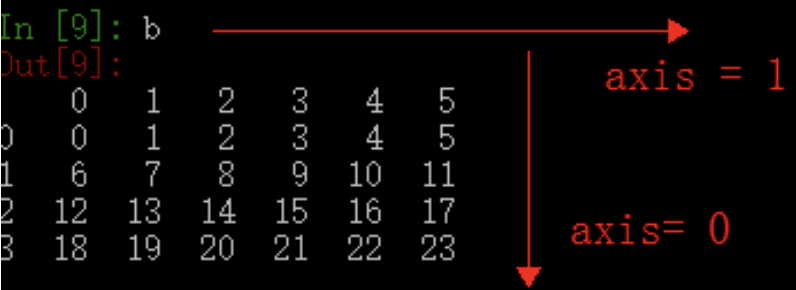

In [164]:
mean_x = np.mean(x , axis=0)
std_x = np.std(x , axis=0)
for i in range(len(x)): # 12*471
    for j in range(len(x[0])): # 18 *9
        if std_x[j]!= 0 :
            x[i][j] = (x[i][j] - mean_x[j]) / std_x[j]
x

array([[-1.35825331, -1.35883937, -1.359222  , ...,  0.26650729,
         0.2656797 , -1.14082131],
       [-1.35825331, -1.35883937, -1.51819928, ...,  0.26650729,
        -1.13963133, -1.32832904],
       [-1.35825331, -1.51789368, -1.67717656, ..., -1.13923451,
        -1.32700613, -0.85955971],
       ...,
       [-0.88092053, -0.72262212, -0.56433559, ..., -0.57693779,
        -0.29644471, -0.39079039],
       [-0.7218096 , -0.56356781, -0.72331287, ..., -0.29578943,
        -0.39013211, -0.1095288 ],
       [-0.56269867, -0.72262212, -0.88229015, ..., -0.38950555,
        -0.10906991,  0.07797893]])

### Split Training Data into "train_set" and "validation_set"

In [165]:
import math
x_train_set = x[: math.floor(len(x)*0.8) , :]
y_train_set = y[: math.floor(len(y)*0.8) , :]
x_validation = x[math.floor(len(x)*0.8) : , :]
y_validation = y[math.floor(len(y)*0.8) : , :]
print(x_train_set)
print(y_train_set)
print(x_validation)
print(y_validation)
print(len(x_train_set))
print(len(y_train_set))
print(len(x_validation))
print(len(y_validation))

[[-1.35825331 -1.35883937 -1.359222   ...  0.26650729  0.2656797
  -1.14082131]
 [-1.35825331 -1.35883937 -1.51819928 ...  0.26650729 -1.13963133
  -1.32832904]
 [-1.35825331 -1.51789368 -1.67717656 ... -1.13923451 -1.32700613
  -0.85955971]
 ...
 [ 0.86929969  0.70886668  0.38952809 ...  1.39110073  0.2656797
  -0.39079039]
 [ 0.71018876  0.39075806  0.07157353 ...  0.26650729 -0.39013211
  -0.39079039]
 [ 0.3919669   0.07264944  0.07157353 ... -0.38950555 -0.39013211
  -0.85955971]]
[[30.]
 [41.]
 [44.]
 ...
 [ 7.]
 [ 5.]
 [14.]]
[[ 0.07374504  0.07264944  0.07157353 ... -0.38950555 -0.85856912
  -0.57829812]
 [ 0.07374504  0.07264944  0.23055081 ... -0.85808615 -0.57750692
   0.54674825]
 [ 0.07374504  0.23170375  0.23055081 ... -0.57693779  0.54674191
  -0.1095288 ]
 ...
 [-0.88092053 -0.72262212 -0.56433559 ... -0.57693779 -0.29644471
  -0.39079039]
 [-0.7218096  -0.56356781 -0.72331287 ... -0.29578943 -0.39013211
  -0.1095288 ]
 [-0.56269867 -0.72262212 -0.88229015 ... -0.3895055

### Trainging

preditc y = x * w + bias

* 參考資料
    - [梯度下降的調適](https://medium.com/@chih.sheng.huang821/機器學習-基礎數學-三-梯度最佳解相關算法-gradient-descent-optimization-algorithms-b61ed1478bd7)

In [166]:
dim = 18 * 9 + 1 # 多一個bias
w = np.zeros([dim , 1])
x = np.concatenate((np.ones([12*471,1]) , x) ,axis = 1).astype(float)
learning_rate = 100
iter_time = 1000
adagrad = np.zeros([dim,1])
eps = 0.0000000001 #eps 項是避免 adagrad 的分母為 0 而加的極小數值。
for i in range(iter_time):
    loss = np.sqrt(np.sum(np.power(np.dot(x,w) - y , 2))/471/12) # Root Mean Square Error
    if i%100 == 0:
        print(str(i) + ":" + str(loss))
    gradient = 2 * np.dot(x.transpose() , np.dot(x,w) - y)
    adagrad += gradient**2
    w = w - learning_rate/np.sqrt(adagrad + eps)*gradient
np.save('weight.npy',w)
w

0:27.071214829194115
100:33.78905859777453
200:19.913751298197095
300:13.531068193689693
400:10.645466158446172
500:9.277353455475067
600:8.518042045956504
700:8.014061987588423
800:7.636756824775695
900:7.336563740371126


array([[ 2.13740269e+01],
       [ 3.58888909e+00],
       [ 4.56386323e+00],
       [ 2.16307023e+00],
       [-6.58545223e+00],
       [-3.38885580e+01],
       [ 3.22235518e+01],
       [ 3.49340354e+00],
       [-4.60308671e+00],
       [-1.02374754e+00],
       [-3.96791501e-01],
       [-1.06908800e-01],
       [ 2.22488184e-01],
       [ 8.99634117e-02],
       [ 1.31243105e-01],
       [ 2.15894989e-02],
       [-1.52867263e-01],
       [ 4.54087776e-02],
       [ 5.20999235e-01],
       [ 1.60824213e-01],
       [-3.17709451e-02],
       [ 1.28529025e-02],
       [-1.76839437e-01],
       [ 1.71241371e-01],
       [-1.31190032e-01],
       [-3.51614451e-02],
       [ 1.00826192e-01],
       [ 3.45018257e-01],
       [ 4.00130315e-02],
       [ 2.54331382e-02],
       [-5.04425219e-01],
       [ 3.71483018e-01],
       [ 8.46357671e-01],
       [-8.11920428e-01],
       [-8.00217575e-02],
       [ 1.52737711e-01],
       [ 2.64915130e-01],
       [-5.19860416e-02],
       [-2.5

### Testing

In [173]:
# read the data
# header = None 必須要加 因為沒有行欄位的說明
test_data = pd.read_csv('./test.csv',header=None,encoding='big5')
# process data
test_data = test_data.iloc[:,2:]
test_data[test_data=='NR'] = 0
# turn to numpy type
test_data = test_data.to_numpy()

test_x = np.empty([240 , 18*9] ,dtype = float) # 4320 / 18 = 240 筆
for i in range(240):
    test_x[i , :] = test_data[18 * i : 18 * (i+1) , :].reshape(1,-1)

# normailze
for i in range(len(test_x)):
    for j in range(len(test_x[0])):
        if std_x[j] != 0:
            test_x[i][j] = (test_x[i][j] - mean_x[j]) / std_x[j]

test_x = np.concatenate((np.ones([240 , 1]),test_x) , axis = 1).astype(float)
test_x

array([[ 1.        , -0.24447681, -0.24545919, ..., -0.67065391,
        -1.04594393,  0.07797893],
       [ 1.        , -1.35825331, -1.51789368, ...,  0.17279117,
        -0.10906991, -0.48454426],
       [ 1.        ,  1.5057434 ,  1.34508393, ..., -1.32666675,
        -1.04594393, -0.57829812],
       ...,
       [ 1.        ,  0.3919669 ,  0.54981237, ...,  0.26650729,
        -0.20275731,  1.20302531],
       [ 1.        , -1.8355861 , -1.8360023 , ..., -1.04551839,
        -1.13963133, -1.14082131],
       [ 1.        , -1.35825331, -1.35883937, ...,  2.98427476,
         3.26367657,  1.76554849]])

### Prediction

In [174]:
w = np.load('./weight.npy')
ans_y = np.dot(test_x,w)
ans_y

array([[ 5.17496040e+00],
       [ 1.83062143e+01],
       [ 2.04912181e+01],
       [ 1.15239429e+01],
       [ 2.66160568e+01],
       [ 2.05313481e+01],
       [ 2.19065510e+01],
       [ 3.17364687e+01],
       [ 1.33916741e+01],
       [ 6.44564665e+01],
       [ 2.02645688e+01],
       [ 1.53585761e+01],
       [ 6.85894728e+01],
       [ 4.84281137e+01],
       [ 1.87023338e+01],
       [ 1.01885957e+01],
       [ 3.07403629e+01],
       [ 7.11322178e+01],
       [-4.13051739e+00],
       [ 1.82356940e+01],
       [ 3.85789223e+01],
       [ 7.13115197e+01],
       [ 7.41034816e+00],
       [ 1.87179553e+01],
       [ 1.49372503e+01],
       [ 3.67197367e+01],
       [ 1.79616970e+01],
       [ 7.57894629e+01],
       [ 1.23093102e+01],
       [ 5.62953517e+01],
       [ 2.51131609e+01],
       [ 4.61024867e+00],
       [ 2.48377055e+00],
       [ 2.47594223e+01],
       [ 3.04802805e+01],
       [ 3.84639307e+01],
       [ 4.42023106e+01],
       [ 3.00868360e+01],
       [ 4.0

### Save Prediction to CSV File

In [175]:
import csv
with open('submit.csv', mode='w', newline='') as submit_file:
    csv_writer = csv.writer(submit_file)
    header = ['id', 'value']
    print(header)
    csv_writer.writerow(header)
    for i in range(240):
        row = ['id_' + str(i), ans_y[i][0]]
        csv_writer.writerow(row)
        print(row)

['id', 'value']
['id_0', 5.174960398984748]
['id_1', 18.306214253527852]
['id_2', 20.491218094180482]
['id_3', 11.523942869805339]
['id_4', 26.61605675230613]
['id_5', 20.531348081761198]
['id_6', 21.906551018797387]
['id_7', 31.73646874706881]
['id_8', 13.391674055111686]
['id_9', 64.45646650291953]
['id_10', 20.264568836159444]
['id_11', 15.35857607736122]
['id_12', 68.58947276926726]
['id_13', 48.428113747457175]
['id_14', 18.70233382419316]
['id_15', 10.188595737466672]
['id_16', 30.740362859820404]
['id_17', 71.13221776355113]
['id_18', -4.130517391262481]
['id_19', 18.23569401642869]
['id_20', 38.578922275007756]
['id_21', 71.31151972531326]
['id_22', 7.410348162634065]
['id_23', 18.71795533032141]
['id_24', 14.937250260084552]
['id_25', 36.71973669470532]
['id_26', 17.96169700566266]
['id_27', 75.78946287210542]
['id_28', 12.309310248614462]
['id_29', 56.295351739649604]
['id_30', 25.113160865661467]
['id_31', 4.610248674094002]
['id_32', 2.4837705545150612]
['id_33', 24.7594222